In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error,mean_squared_error,mean_absolute_error,mean_absolute_percentage_error,r2_score
import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

from keras.models import Sequential
from keras.layers import Dense
from prettytable import PrettyTable

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('vehicles2_rec.csv')
df.head()

,region,price,year,manufacturer,model,fuel,odometer,title_status,transmission,condition,...,state,image_url,posting_date,postmd,Age,avg_mil,mil_rating,Made,type_group,color_group
0,bakersfield,11975,2003,harley-davidson,davidson,gas,207000.0,clean,automatic,excellent,...,ca,https://images.craigslist.org/00F0F_eEBhgvA15M...,2021-05-04T12:26:43-0700,May-04,22,9409.090909,below average,American,non-luxury_small,dark color
1,bakersfield,21950,2003,chevrolet,silverado 3500,diesel,202537.0,clean,automatic,excellent,...,ca,https://images.craigslist.org/00m0m_9owDGrPLWK...,2021-05-04T12:04:51-0700,May-04,22,9206.227273,below average,American,non-luxury_small,dark color
2,bakersfield,15590,2015,mini,hardtop 2 door cooper s,other,60291.0,clean,other,good,...,ca,https://images.craigslist.org/00f0f_dGlIKGTKrJ...,2021-05-04T11:41:15-0700,May-04,10,6029.100000,below average,English,luxury_small,dark color
3,bakersfield,3975,2006,pontiac,g6,gas,187000.0,clean,automatic,excellent,...,ca,https://images.craigslist.org/00V0V_5uw5gVZjSk...,2021-05-04T11:35:04-0700,May-04,19,9842.105263,below average,American,luxury_small,light color
4,bakersfield,8000,1972,chevrolet,chevelle,gas,61000.0,clean,automatic,fair,...,ca,https://images.craigslist.org/00U0U_gvATaIvxTn...,2021-05-04T11:30:14-0700,May-04,53,1150.943396,below average,American,luxury_small,light color


In [3]:
df.columns

Index(['region', 'price', 'year', 'manufacturer', 'model', 'fuel', 'odometer',
       'title_status', 'transmission', 'condition', 'cylinders', 'drive',
       'type', 'paint_color', 'state', 'image_url', 'posting_date', 'postmd',
       'Age', 'avg_mil', 'mil_rating', 'Made', 'type_group', 'color_group'],
      dtype='object')

In [4]:
df.drop(['region', 'state', 'image_url', 'posting_date', 'postmd', 'Age', 'avg_mil', 'Made', 'type_group', 'color_group'],axis=1,inplace=True)
df.columns

Index(['price', 'year', 'manufacturer', 'model', 'fuel', 'odometer',
       'title_status', 'transmission', 'condition', 'cylinders', 'drive',
       'type', 'paint_color', 'mil_rating'],
      dtype='object')

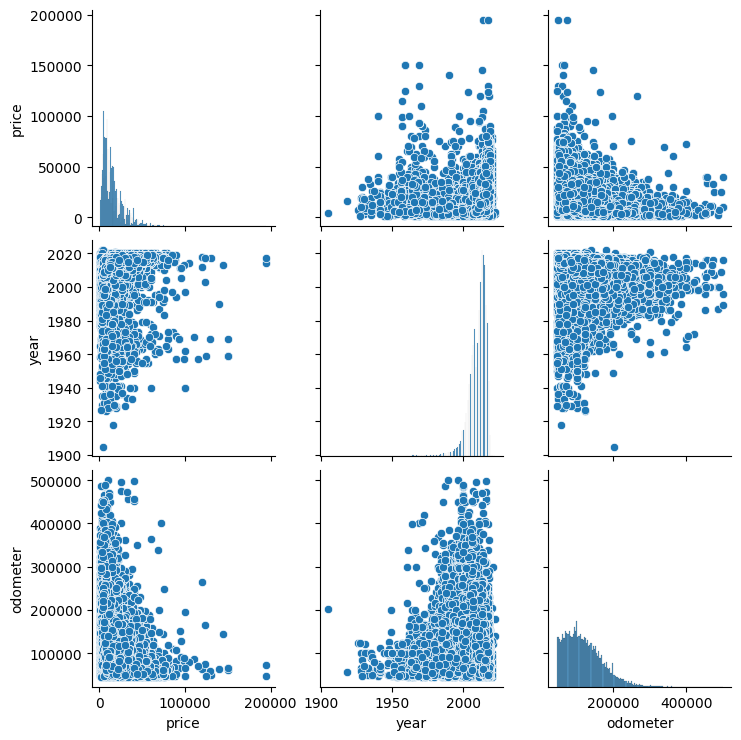

In [5]:
sns.pairplot(df)

In [6]:
df.cylinders.value_counts()

cylinders
6 cylinders     38412
4 cylinders     34406
8 cylinders     29046
5 cylinders       946
10 cylinders      519
other             349
3 cylinders       130
12 cylinders       34
Name: count, dtype: int64

In [7]:
df.cylinders.replace("other",np.nan,inplace=True)
df.cylinders.value_counts()

cylinders
6 cylinders     38412
4 cylinders     34406
8 cylinders     29046
5 cylinders       946
10 cylinders      519
3 cylinders       130
12 cylinders       34
Name: count, dtype: int64

In [8]:
#normalize the cylinders value counts and save into a dataframe
cyl_prob = pd.DataFrame(list(df.cylinders.value_counts(normalize=True).items()),columns = ['cylinders','prob'])
#substitute missing values in cylinder to random states based on their probabilities
df.loc[df.cylinders.isna(), 'cylinders'] = np.random.choice(cyl_prob.cylinders, 
                                                size=df.cylinders.isna().sum(),
                                                replace=True, 
                                                p=cyl_prob.prob)
df.cylinders.value_counts()

cylinders
6 cylinders     38553
4 cylinders     34523
8 cylinders     29134
5 cylinders       947
10 cylinders      521
3 cylinders       130
12 cylinders       34
Name: count, dtype: int64

In [9]:
#since cylinder has the word 'cylinder' after the number, we remove it and make it numerical
df['cylinders']=df['cylinders'].apply(lambda x:x.split(' ')[0])
df['cylinders']=df['cylinders'].astype('int')
df['cylinders'].dtype

dtype('int64')

<Axes: ylabel='odometer'>

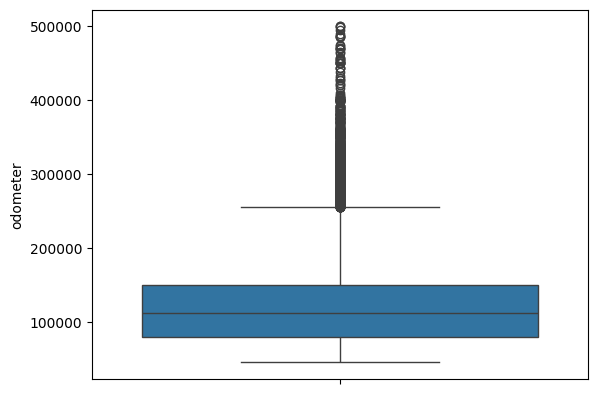

In [10]:
sns.boxplot(df['odometer'])

<Axes: ylabel='cylinders'>

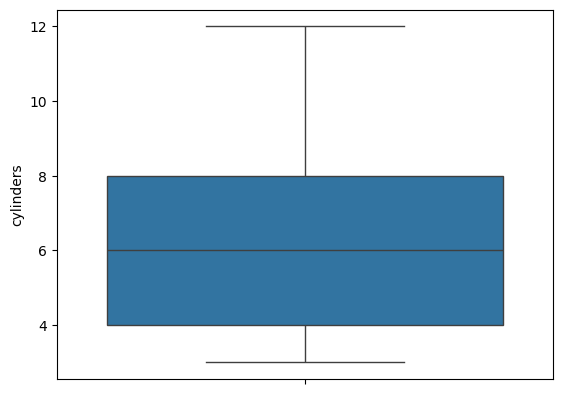

In [11]:
sns.boxplot(df['cylinders'])

odometer
--------------------------------------------------
Percentiles: 25th=79393.000, 75th=150000.000, IQR=70607.000
Lower: -26517.5  Upper: 255910.5
Identified outliers: 1653
Non-outlier observations: 102189


<Axes: >

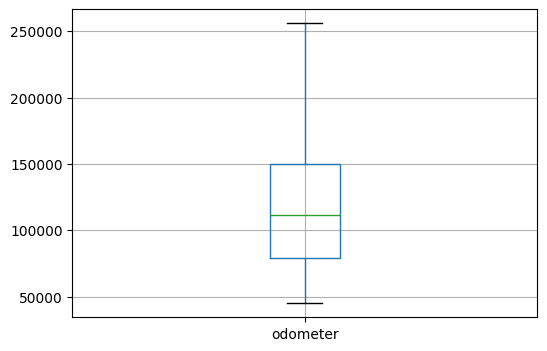

In [12]:
#further remove outliers in odometer for model purposes
def find_outliers_limit(df,col):
    print(col)
    print('-'*50)
    #removing outliers
    q25, q75 = np.percentile(df[col], 25), np.percentile(df[col], 75)
    iqr = q75 - q25
    print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q25, q75, iqr))
    # calculate the outlier cutoff
    cut_off = iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off
    print('Lower:',lower,' Upper:',upper)
    return lower,upper
def remove_outlier(df,col,upper,lower):
    # identify outliers
    outliers = [x for x in df[col] if x > upper or x < lower]
    print('Identified outliers: %d' % len(outliers))
    # remove outliers
    outliers_removed = [x for x in df[col] if x >= lower and x <= upper]
    print('Non-outlier observations: %d' % len(outliers_removed))
    final= np.where(df[col]>upper,upper,np.where(df[col]<lower,lower,df[col]))
    return final
outlier_cols=['odometer']
for col in outlier_cols:
    lower,upper=find_outliers_limit(df,col)
    df[col]=remove_outlier(df,col,upper,lower)
    
plt.figure(figsize=(6,4))
df[outlier_cols].boxplot()

In [13]:
#select numerical and categorical data
num_df=df.select_dtypes(include=np.number)
cat_df=df.select_dtypes(include=object)
#assign encoder
encoding=OrdinalEncoder()
#place categorical columns to list and encode
cat_cols=cat_df.columns.tolist()
encoding.fit(cat_df[cat_cols])
#transform categorical encoding and place in dataframe
cat_oe=encoding.transform(cat_df[cat_cols])
cat_oe=pd.DataFrame(cat_oe,columns=cat_cols)
cat_df.reset_index(inplace=True,drop=True)

cat_oe.head()

num_df.reset_index(inplace=True,drop=True)

cat_oe.reset_index(inplace=True,drop=True)

final_all_df=pd.concat([num_df,cat_oe],axis=1)

<Axes: >

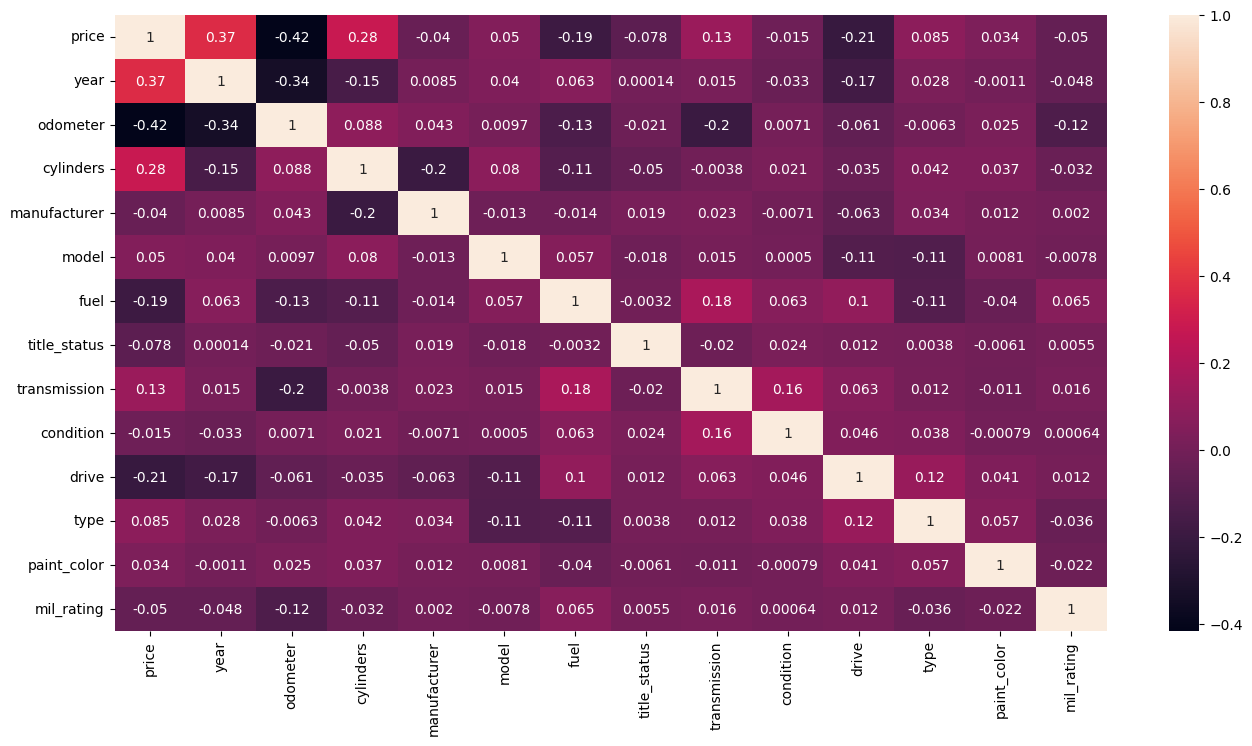

In [14]:
#plot the correlation matrix
plt.figure(figsize=(16,8))
sns.heatmap(data=final_all_df.corr(),annot=True)

In [15]:
df.columns

Index(['price', 'year', 'manufacturer', 'model', 'fuel', 'odometer',
       'title_status', 'transmission', 'condition', 'cylinders', 'drive',
       'type', 'paint_color', 'mil_rating'],
      dtype='object')

In [16]:
data_reg = df.loc[:, ['price', 'year', 'odometer', 'cylinders', 'manufacturer', 'model', 'fuel', 'title_status',
                       'transmission', 'condition', 'drive', 'type',
                       'paint_color', 'mil_rating']]
label_reg = data_reg
data_reg_original = data_reg
data_reg.head()

,price,year,odometer,cylinders,manufacturer,model,fuel,title_status,transmission,condition,drive,type,paint_color,mil_rating
0,11975,2003,207000.0,8,harley-davidson,davidson,gas,clean,automatic,excellent,rwd,pickup,black,below average
1,21950,2003,202537.0,8,chevrolet,silverado 3500,diesel,clean,automatic,excellent,4wd,truck,grey,below average
2,15590,2015,60291.0,6,mini,hardtop 2 door cooper s,other,clean,other,good,rwd,hatchback,red,below average
3,3975,2006,187000.0,4,pontiac,g6,gas,clean,automatic,excellent,fwd,sedan,silver,below average
4,8000,1972,61000.0,8,chevrolet,chevelle,gas,clean,automatic,fair,rwd,convertible,white,below average


In [17]:
data_reg.to_csv('vehicle_label_data.csv', index=False)

In [17]:
lreg = data_reg.copy()

In [53]:
# create a new dictionary for mapping original values
encoded_dict = {}

In [171]:
# encoded column using LabelEncoder
# transmission_encoder = LabelEncoder()
# manufacturer_encoder = LabelEncoder()
# fuel_encoder = LabelEncoder()
# title_status_encoder = LabelEncoder()
# condition_encoder = LabelEncoder()
# drive_encoder = LabelEncoder()
# type_encoder = LabelEncoder()
# paint_color_encoder = LabelEncoder()
# mil_rating_encoder = LabelEncoder()
model_encoder = LabelEncoder()

# lreg['transmission_encoded'] = transmission_encoder.fit_transform(lreg['transmission'])
# lreg['manufacturer_encoded'] = manufacturer_encoder.fit_transform(lreg['manufacturer'])
# lreg['fuel_encoded'] = fuel_encoder.fit_transform(lreg['fuel'])
# lreg['title_status_encoded'] = title_status_encoder.fit_transform(lreg['title_status'])
# lreg['condition_encoded'] = condition_encoder.fit_transform(lreg['condition'])
# lreg['drive_encoded'] = drive_encoder.fit_transform(lreg['drive'])
# lreg['type_encoded'] = type_encoder.fit_transform(lreg['type'])
# lreg['paint_color_encoded'] = paint_color_encoder.fit_transform(lreg['paint_color'])
# lreg['mil_rating_encoded'] = mil_rating_encoder.fit_transform(lreg['mil_rating'])
lreg['model_encoded'] = model_encoder.fit_transform(lreg['model'])

# Get the unique original values of column
# original_values = lreg['transmission'].unique()
# original_values = lreg['manufacturer'].unique()
# original_values = lreg['fuel'].unique()
# original_values = lreg['title_status'].unique()
# original_values = lreg['condition'].unique()
# original_values = lreg['drive'].unique()
# original_values = lreg['type'].unique()
# original_values = lreg['paint_color'].unique()
# original_values = lreg['mil_rating'].unique()
original_values = lreg['model'].unique()

# Create a dictionary to store the mapping of original values to encoded values
mapping = {}
for value in original_values:
    # encoded_value = transmission_encoder.transform([value])[0]
    # encoded_value = manufacturer_encoder.transform([value])[0]
    # encoded_value = fuel_encoder.transform([value])[0]
    # encoded_value = title_status_encoder.transform([value])[0]
    # encoded_value = condition_encoder.transform([value])[0]
    # encoded_value = drive_encoder.transform([value])[0]
    # encoded_value = type_encoder.transform([value])[0]
    # encoded_value = paint_color_encoder.transform([value])[0]
    # encoded_value = mil_rating_encoder.transform([value])[0]
    encoded_value = model_encoder.transform([value])[0]
    
    mapping[value] = encoded_value


# encoded_dict['encoded_manufacturer'] = mapping
# encoded_dict['encoded_transmission'] = mapping
# encoded_dict['encoded_fuel'] = mapping
# encoded_dict['encoded_title_status'] = mapping
# encoded_dict['encoded_condition'] = mapping
# encoded_dict['encoded_drive'] = mapping
# encoded_dict['encoded_type'] = mapping
# encoded_dict['encoded_paint_color'] = mapping
# encoded_dict['encoded_mil_rating'] = mapping
encoded_dict['encoded_model'] = mapping

mapping

{'davidson': 3316,
 'silverado 3500': 8733,
 'hardtop 2 door cooper s': 5715,
 'g6': 5387,
 'chevelle': 2552,
 'vanagon': 9997,
 'rx 350': 7979,
 'leaf': 6213,
 'altima ￼': 1566,
 'corolla s': 2908,
 '2500': 286,
 'tl special edition sedan': 9571,
 '4runner': 855,
 '2500 quad cab': 391,
 'f250 super duty': 4734,
 'silverado 2500 hd': 8685,
 'f-150 lifted lariat supercrew 5.0 v8': 4243,
 'f-150 xlt supercrew ecoboost 3.5l premium': 4303,
 '3500 laramie drw crew cab cummins': 738,
 'astro transit van': 1611,
 'soul': 8986,
 'accord': 1383,
 'tahoe': 9346,
 'gti': 5680,
 '500': 941,
 'cr-v': 2976,
 'forte koup sx coupe 2d': 5169,
 'cl-class cl 550': 2671,
 'f-150': 4196,
 'ranger xl': 7701,
 'mustang gt': 6857,
 'forte': 5159,
 'yukon': 10564,
 'g37': 5363,
 'benz e350 sport': 1885,
 'chassis 3500': 2502,
 'sierra': 8418,
 'ridgeline rtl-t pickup 4d': 7857,
 'bronco eddie bauer': 2034,
 '1500': 46,
 '650i convertible': 1087,
 'f-250': 4310,
 'camaro': 2228,
 'yaris': 10547,
 'truck tundra

In [18]:
label_reg = data_reg

le_manufacturer = LabelEncoder()
le_mil = LabelEncoder()
le_fuel = LabelEncoder()
le_transmission = LabelEncoder()
le_condition = LabelEncoder()
le_drive = LabelEncoder()
le_type = LabelEncoder()
le_color = LabelEncoder()
le_title_status = LabelEncoder()
le_model = LabelEncoder()

label_reg["manufacturer"] = le_manufacturer.fit_transform(label_reg['manufacturer'])
label_reg["fuel"] = le_fuel.fit_transform(label_reg['fuel'])
label_reg["title_status"] = le_title_status.fit_transform(label_reg['title_status'])
label_reg['transmission'] = le_transmission.fit_transform(label_reg['transmission'])
label_reg['condition'] = le_condition.fit_transform(label_reg['condition'])
label_reg['drive'] = le_drive.fit_transform(label_reg['drive'])
label_reg["type"] = le_type.fit_transform(label_reg['type'])
label_reg['paint_color'] = le_color.fit_transform(label_reg['paint_color'])
label_reg['mil_rating'] = le_mil.fit_transform(label_reg['mil_rating'])
label_reg['model'] = le_model.fit_transform(label_reg['model'])

label_reg.head()

,price,year,odometer,cylinders,manufacturer,model,fuel,title_status,transmission,condition,drive,type,paint_color,mil_rating
0,11975,2003,207000.0,8,14,3316,2,0,0,0,2,8,0,1
1,21950,2003,202537.0,8,6,8733,0,0,0,0,0,10,5,1
2,15590,2015,60291.0,6,27,5715,4,0,2,2,2,4,8,1
3,3975,2006,187000.0,4,30,5387,2,0,0,0,1,9,9,1
4,8000,1972,61000.0,8,6,2552,2,0,0,1,2,2,10,1


In [19]:
price_col = label_reg['price']
price_col.head()

0    11975
1    21950
2    15590
3     3975
4     8000
Name: price, dtype: int64

In [20]:
label_reg.drop('price',axis=1,inplace=True)
label_reg.columns

Index(['year', 'odometer', 'cylinders', 'manufacturer', 'model', 'fuel',
       'title_status', 'transmission', 'condition', 'drive', 'type',
       'paint_color', 'mil_rating'],
      dtype='object')

In [257]:
scaler = StandardScaler()
label_reg = pd.DataFrame(scaler.fit_transform(label_reg), columns=label_reg.columns)
label_reg.head()

,year,manufacturer,model,fuel,odometer,title_status,transmission,condition,cylinders,drive,type,paint_color,mil_rating
0,-0.895047,-0.348962,-0.723190,0.063929,1.763490,-0.181098,-0.361688,-0.956607,1.310192,1.654337,0.475848,-1.387944,0.06296
1,-0.895047,-1.054728,1.075010,-2.862468,1.673967,-0.181098,-0.361688,-0.956607,1.310192,-0.992735,0.959568,-0.153903,0.06296
2,0.707790,0.797909,0.073170,2.990326,-1.179334,-0.181098,3.399606,0.823512,0.059199,1.654337,-0.491593,0.586522,0.06296
3,-0.494338,1.062572,-0.035711,0.063929,1.362312,-0.181098,-0.361688,-0.956607,-1.191793,0.330801,0.717708,0.833330,0.06296
4,-5.035710,-1.054728,-0.976803,0.063929,-1.165112,-0.181098,-0.361688,-0.066547,1.310192,1.654337,-0.975313,1.080138,0.06296


In [21]:
t_lreg = label_reg.copy()
t_lreg.head()

,year,odometer,cylinders,manufacturer,model,fuel,title_status,transmission,condition,drive,type,paint_color,mil_rating
0,2003,207000.0,8,14,3316,2,0,0,0,2,8,0,1
1,2003,202537.0,8,6,8733,0,0,0,0,0,10,5,1
2,2015,60291.0,6,27,5715,4,0,2,2,2,4,8,1
3,2006,187000.0,4,30,5387,2,0,0,0,1,9,9,1
4,1972,61000.0,8,6,2552,2,0,0,1,2,2,10,1


In [32]:
X_regla = t_lreg.drop(['paint_color', 'mil_rating'], axis = 1)
# X_regla = t_lreg
y_regla = price_col
X_train, X_test, y_train, y_test = train_test_split(X_regla, y_regla, test_size = 0.15, random_state = 42)

In [33]:
X_regla.columns

Index(['year', 'odometer', 'cylinders', 'manufacturer', 'model', 'fuel',
       'title_status', 'transmission', 'condition', 'drive', 'type'],
      dtype='object')

## Model Training

In [34]:
# KNeighborsRegressor
model_knr = KNeighborsRegressor(n_neighbors=4).fit(X_train,y_train)

In [35]:
# DecisionTreeRegressor
model_dtr = DecisionTreeRegressor().fit(X_train,y_train)

In [36]:
# RandomForestRegressor
model_rf = RandomForestRegressor().fit(X_train,y_train)

In [37]:
# Model evaluation
def model_evaluate(model,x,y):
    predictions=model.predict(x)
    
    mse=mean_squared_error(y,predictions)
    mae=mean_absolute_error(y,predictions)
    mape=mean_absolute_percentage_error(y,predictions)
    
    mse=round(mse,2)
    mae=round(mae,2)
    mape=round(mape,2)
    
    score = model.score(x,y)
    
    return [mse,mae,mape,score]

summary=PrettyTable(['Model','MSE','MAE','MAPE', 'SCORE'])
summary.add_row(['KNR']+model_evaluate(model_knr,X_test,y_test))
summary.add_row(['DTR']+model_evaluate(model_dtr,X_test,y_test))
summary.add_row(['RF']+model_evaluate(model_rf,X_test,y_test))

print(summary)

+-------+-------------+---------+------+--------------------+
| Model |     MSE     |   MAE   | MAPE |       SCORE        |
+-------+-------------+---------+------+--------------------+
|  KNR  |  61547624.2 | 4634.07 | 0.54 | 0.5590183571701685 |
|  DTR  | 28251221.49 | 2475.65 | 0.28 | 0.7975832499411172 |
|   RF  | 16031566.49 |  2086.9 | 0.24 | 0.8851356714866453 |
+-------+-------------+---------+------+--------------------+


In [38]:
knr=KNeighborsRegressor(n_neighbors=3).fit(X_train,y_train)
knr.score(X_test, y_test)

0.5684739204336651

In [39]:
model_rf.score(X_test, y_test)

0.8851356714866453

In [40]:
model_dtr.score(X_test, y_test)

0.7975832499411172

In [41]:
model_knr.score(X_test, y_test)

0.5590183571701685

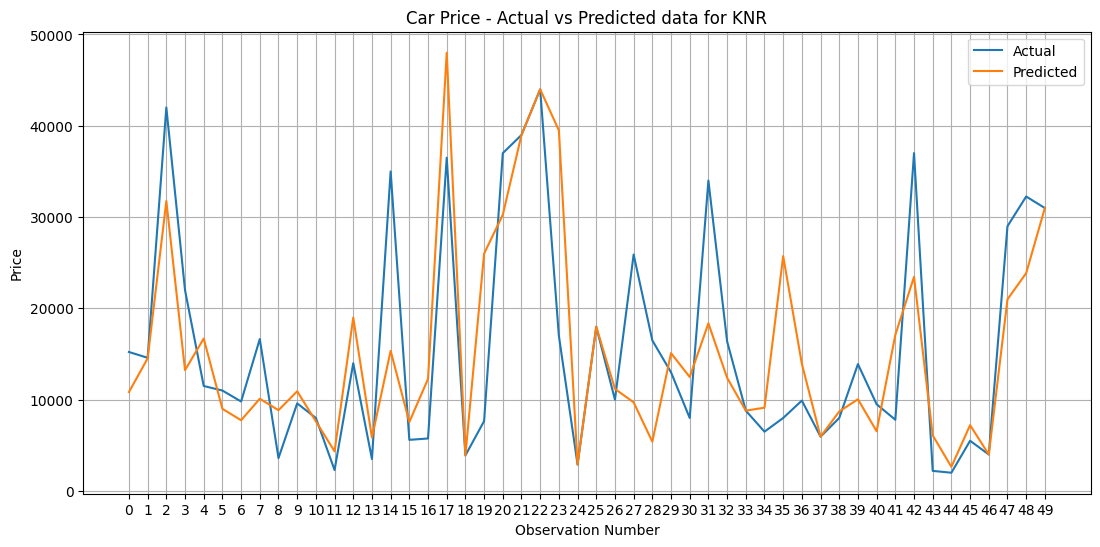

In [49]:
#plot the actual vs the predicted price
y_pred=(model_knr.predict(X_test))

number_of_observations=50

x_ax = range(len(y_test[:number_of_observations]))

plt.figure(figsize=(13,6))
plt.plot(x_ax, y_test[:number_of_observations], label="Actual")
plt.plot(x_ax, y_pred[:number_of_observations], label="Predicted")
plt.title("Car Price - Actual vs Predicted data for KNR")
plt.xlabel('Observation Number')
plt.ylabel('Price')
plt.xticks(np.arange(number_of_observations))
plt.legend()
plt.grid()
plt.show()

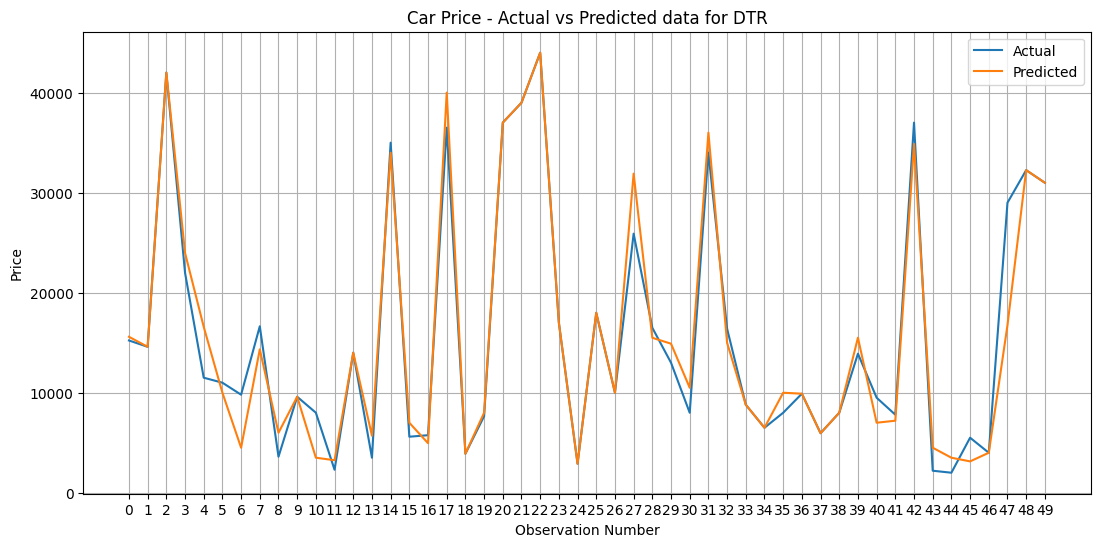

In [50]:
#plot the actual vs the predicted price
y_pred=(model_dtr.predict(X_test))

number_of_observations=50

x_ax = range(len(y_test[:number_of_observations]))

plt.figure(figsize=(13,6))
plt.plot(x_ax, y_test[:number_of_observations], label="Actual")
plt.plot(x_ax, y_pred[:number_of_observations], label="Predicted")
plt.title("Car Price - Actual vs Predicted data for DTR")
plt.xlabel('Observation Number')
plt.ylabel('Price')
plt.xticks(np.arange(number_of_observations))
plt.legend()
plt.grid()
plt.show()

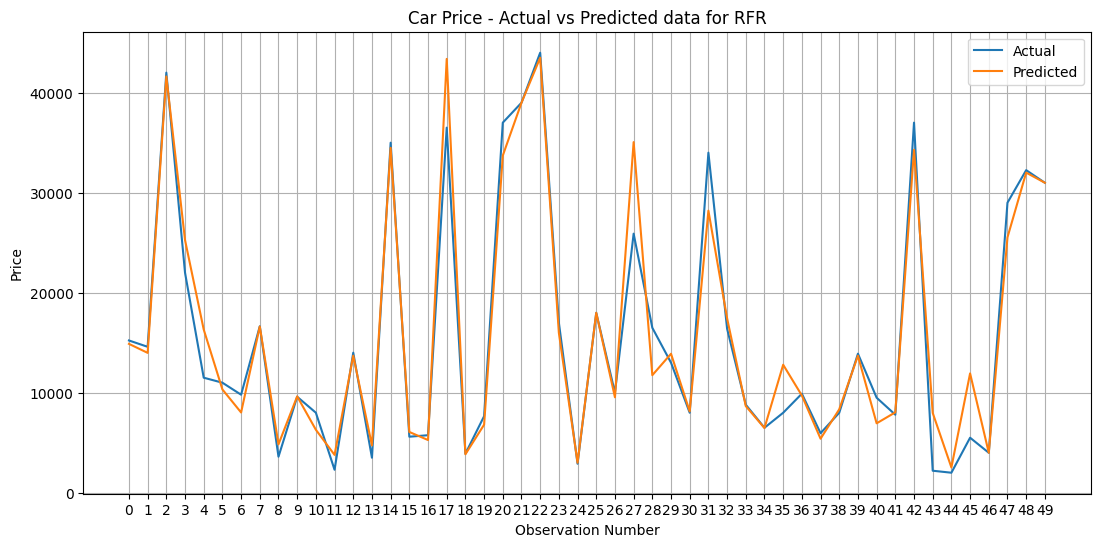

In [51]:
#plot the actual vs the predicted price
y_pred=(model_rf.predict(X_test))

number_of_observations=50

x_ax = range(len(y_test[:number_of_observations]))

plt.figure(figsize=(13,6))
plt.plot(x_ax, y_test[:number_of_observations], label="Actual")
plt.plot(x_ax, y_pred[:number_of_observations], label="Predicted")
plt.title("Car Price - Actual vs Predicted data for RFR")
plt.xlabel('Observation Number')
plt.ylabel('Price')
plt.xticks(np.arange(number_of_observations))
plt.legend()
plt.grid()
plt.show()

In [54]:
import joblib
joblib.dump(model_rf, 'pred_price_model.pkl', compress=7)

['pred_price_model.pkl']

In [53]:
loaded_model = joblib.load(open('pred_price_model.pkl','rb'))
loaded_model.score(X_test, y_test)

0.8851356714866453

In [61]:
loaded_model = joblib.load(open('pred_price_model.pkl','rb'))

In [62]:
def predict(year, manufacturer, model, fuel, odometer, title_status, transmission, condition, cylinders, drive, type):
    pred = (year, manufacturer, model, fuel, odometer, title_status, transmission, condition, cylinders, drive, type)
    x = np.array([pred])
    #convert input using LabelEncoder
    # le_reg = [np.nan,np.nan,np.nan,le_manufacturer, le_model,le_fuel,le_transmission,
    #               le_condition,le_drive,le_type]
    
    # for i in range(3,10):
    #     x[:,i] = le_reg[i].transform(x[:,i])
    #     x
       
    price_est = loaded_model.predict(x)
    return "Price Estimate =  $" + str(price_est)

In [63]:
predict(2003, 14, 3316, 2, 207000.0, 0, 0, 0, 8, 2, 8)

'Price Estimate =  $[26164.72]'